# Tests

### Imports

In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import itertools

from scipy.spatial import cKDTree
from scipy         import sparse
from scipy.sparse  import linalg as sparse_linalg
from scipy.interpolate import interp1d
from numba         import njit

In [2]:
dimension = 1
npoints   = 200
nquads    = 1

r_in   = 1.0E13   # [m]
r_out  = 7.8E16   # [m]
nH2_in = 2.0E13   # [m^-3]
temp   = 2.0E+01  # [K]
turb   = 1.5E+02  # [m/s]

rs = np.logspace (np.log10(r_in), np.log10(r_out), npoints, endpoint=True)

X_mol = 1.0E-8

def nH2 (r):
    return nH2_in * np.power(r_in/r, 2.0)

def nTT (r):
    return X_mol  * nH2(r)

In [3]:
Nb = 10
Nd = 10
Nt = npoints

In [4]:
r_in  =  1.0
r_out =  5.0

xs = rs[::20]
xt = rs
ys = nTT(xs)
yt = nTT(xt)

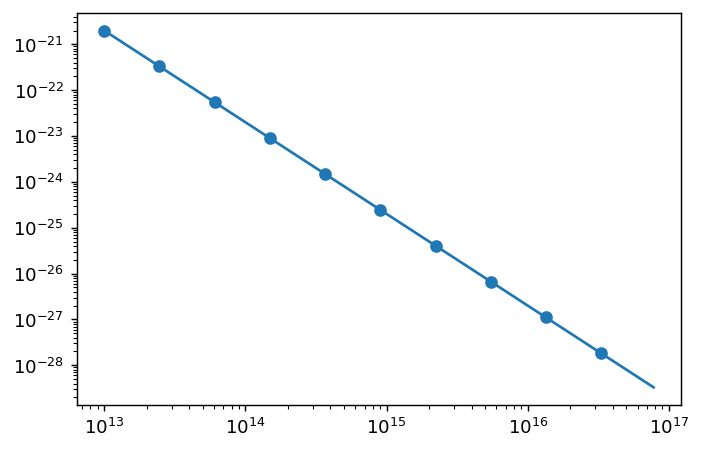

In [5]:
plt.figure(dpi=130)
plt.scatter(xs, ys)
plt.plot   (xt, yt)
plt.xscale('log')
plt.yscale('log')

In [108]:
hh = interp1d(0.5*(rs[:-1]+rs[1:]), 1.0*np.diff(rs),fill_value='extrapolate')

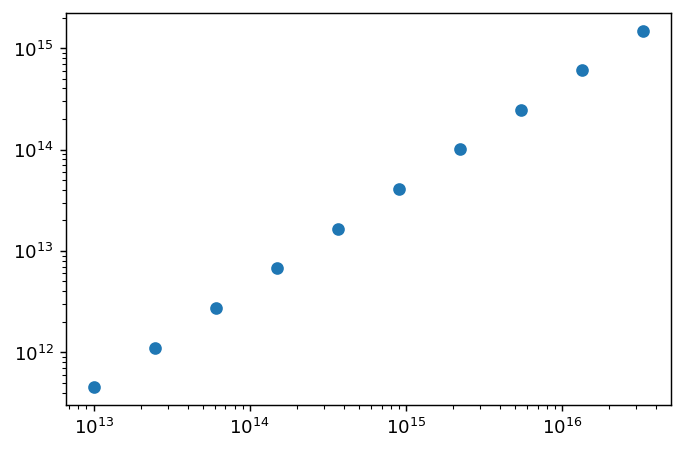

In [109]:
plt.figure(dpi=130)
plt.scatter(xs, hh(xs))
plt.xscale('log')
plt.yscale('log')

In [17]:
def RBF_Lucy(r):
    """
    Lucy's smoothing kernel (Lucy 1977).
    """
    # Ensure to take the absolute value
    rr = np.abs(r)
    # Compute Lucy's kernel
    if (rr < 1.0):
        return (1.0 + 3.0*rr) * (1 - rr)**3
    else:
        return 0.0

def grad_RBF_Lucy(r):
    # Ensure to take the absolute value
    rr = np.abs(r)
    # Compute the gradient of Lucy's kernel
    if (rr < 1.0):
        return -12.0 * (rr - 1.0)**2 * rr * np.sign(r)
    else:
        return 0.0

def grad2_RBF_Lucy(r):
    # Ensure to take the absolute value
    rr = np.abs(r)
    # Compute the gradient^2 of Lucy's kernel
    if (rr < 1.0):
        return -12.0 * (rr - 1.0) * (3.0 * rr - 1.0)
    else:
        return 0.0

In [140]:
def RBF_Gauss(r):
    """
    Gaussian kernel.
    """
    # Ensure to take the absolute value
    rr = np.abs(r)
    # Compute Gaussian kernel
    return np.exp(-0.5*rr**2)

def grad_RBF_Gauss(r):
    return -r * RBF_Gauss(r)

def grad2_RBF_Gauss(r):
    return -RBF_Gauss(r) - r*grad_RBF_Gauss(r)

In [141]:
def RBF_Lucy(r):
    """
    Lucy's smoothing kernel (Lucy 1977).
    """
    if isinstance(r, np.ndarray):
        # Ensure to take the absolute value
        rr = np.abs(r)
        # Compute Lucy's kernel
        result          = (1.0 + 3.0*rr) * (1 - rr)**3
        result[rr>=1.0] = 0.0
        return result
    else:
        # Ensure to take the absolute value
        rr = np.abs(r)
        # Compute Lucy's kernel
        if (rr < 1.0):
            return (1.0 + 3.0*rr) * (1 - rr)**3
        else:
            return 0.0

In [142]:
def RBF(r):
#     print(r)
    return RBF_Gauss(r)

grad_RBF = grad_RBF_Gauss

In [143]:
# Define Gaussian (RBF) feature map
Phi = np.zeros((Nd, Nb))
for d in range(Nd):
    xd = xs[d]
    for i in range(Nb):
        xi = xs[i]
        rr = np.abs(xi - xd)
        Phi[d,i] = RBF(rr/hh(xi))

# Corresponding expansion
def f(x,w):
    result = np.zeros(x.shape)
    for i in range(Nb):
        xi = xs[i]
        rr = np.abs(xi - x)
        result += w[i]*rbf(0.1*rr/hh(xi))
    return result

In [147]:
NB = 1
NL = 5
Nd = NL + NB

# Define Gaussian (RBF) feature map
Phi = np.zeros((Nd, Nb))
for d in range(NL):
    xd = xs[d]
    for i in range(Nb):
        xi = xs[i]
        rr = xi - xd
        Phi[d,i] = RBF(rr/hh(xi)) + grad_RBF(rr/hh(xi)) 
for d in range(NL, Nd):
    xd = xs[d]
    for i in range(Nb):
        xi = xs[i]
        rr = xi - xd
        Phi[d,i] = RBF(rr/hh(xi))
    

# Corresponding expansion
def f(x,w):
    result = np.zeros(x.shape)
    for i in range(Nb):
        xi = xs[i]
        rr = xi - x
        result += w[i] * RBF(rr/hh(xi))
    return result

In [148]:
Phi

array([[ 1.00000000e+000, -2.14846555e-037, -3.80658396e-074,
        -1.18728011e-092, -9.25606805e-101, -3.75777147e-104,
        -1.51688084e-105, -4.09207850e-106, -2.40063026e-106,
        -1.93263141e-106],
       [ 6.48209704e-228,  1.00000000e+000, -2.14846555e-037,
        -3.80658396e-074, -1.18728011e-092, -9.25606805e-101,
        -3.75777147e-104, -1.51688084e-105, -4.09207850e-106,
        -2.40063026e-106],
       [ 0.00000000e+000,  6.48209704e-228,  1.00000000e+000,
        -2.14846555e-037, -3.80658396e-074, -1.18728011e-092,
        -9.25606805e-101, -3.75777147e-104, -1.51688084e-105,
        -4.09207850e-106],
       [ 0.00000000e+000,  0.00000000e+000,  6.48209704e-228,
         1.00000000e+000, -2.14846555e-037, -3.80658396e-074,
        -1.18728011e-092, -9.25606805e-101, -3.75777147e-104,
        -1.51688084e-105],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         6.48209704e-228,  1.00000000e+000, -2.14846555e-037,
        -3.80658396e-074

In [149]:
K = np.matmul(Phi, Phi.T)
M = np.matmul(Phi.T, Phi)

In [152]:
print(np.linalg.det(K))
print(np.linalg.det(M))

1.0
0.0


In [153]:
# mat = np.matmul(K.T, K)
# w_K = np.matmul(np.linalg.solve(mat, ys).T, np.matmul(K.T, Phi))
mat = K
w_K = np.matmul(np.linalg.solve(mat, ys).T, Phi)
print(np.linalg.cond(mat), mat.shape)

ValueError: solve1: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (m,m),(m)->(m) (size 10 is different from 6)

In [154]:
w_K

array([2.00000000e-21, 3.30140969e-22, 5.44965299e-23, 8.99576860e-24,
       1.48493588e-24, 2.45119086e-25, 4.04619264e-26, 6.67906980e-27,
       1.10251729e-27, 1.81993063e-28])

In [155]:
mat = M
w_M = np.linalg.solve(mat, np.matmul(Phi.T, ys))
print(np.linalg.cond(mat), mat.shape)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 10 is different from 6)

In [138]:
w_M

array([2.00000000e-21, 3.30140969e-22, 5.44965299e-23, 8.99576860e-24,
       1.48493588e-24, 2.45119086e-25, 4.04619264e-26, 6.67906980e-27,
       1.10251729e-27, 1.81993063e-28])

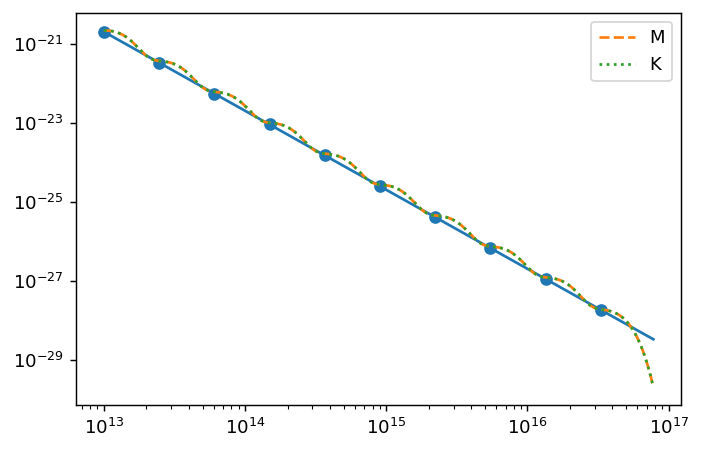

In [139]:
plt.figure(dpi=130)
plt.scatter(xs, ys)
plt.plot   (xt, yt)
plt.plot   (xt, f(xt, w_M), label='M', linestyle='dashed')
plt.plot   (xt, f(xt, w_K), label='K', linestyle='dotted')
# plt.plot   (xt, f(xt, np.identity(Nb)[2]))
plt.legend()

plt.xscale('log')
plt.yscale('log')

No handles with labels found to put in legend.


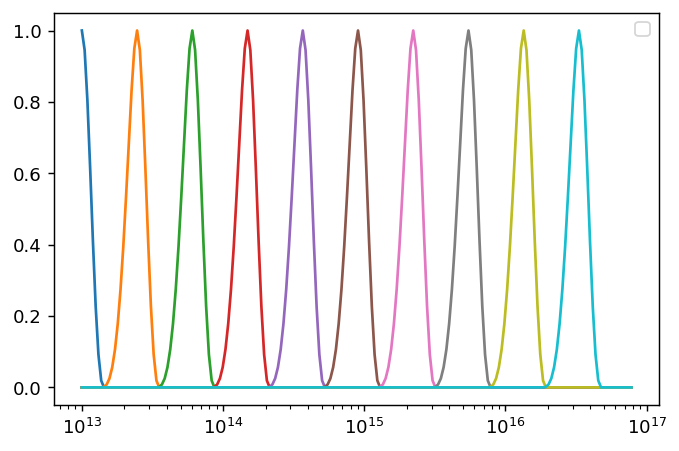

In [121]:
plt.figure(dpi=130)
# plt.scatter(xs, ys)
# plt.plot   (xt, yt)
# plt.plot   (xt, f(xt, w_M), label='M', linestyle='dashed')
# plt.plot   (xt, f(xt, w_K), label='K', linestyle='dotted')

for i in range(Nb):
    plt.plot(xt, f(xt, np.identity(Nb)[i]))

plt.legend()

plt.xscale('log')
# plt.yscale('log')

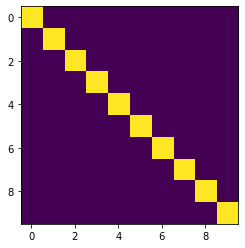

In [122]:
plt.imshow(K)

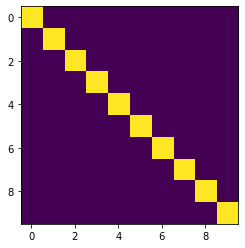

In [123]:
plt.imshow(M)